<a href="https://colab.research.google.com/github/eunhaday/AIFFEL_quest_cr/blob/master/AIFFELTHON_PRJ/pymunk_test_neh_0108_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# pip를 사용하여 Ultralytics 설치
!pip install pymunk
!pip install ultralytics
!pip show pymunk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 27.3 MB/s eta 0:00:00
Name: pymunk
Version: 6.10.0
Summary: Pymunk is a easy-to-use pythonic 2D physics library
Home-page: https://www.pymunk.org
Author: 
Author-email: Victor Blomqvist <vb@viblo.se>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cffi
Required-by: 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 736x1280 1 frame, 2 red balls, 1 table, 1 white ball, 1 yellow ball, 1475.3ms
Speed: 28.0ms preprocess, 1475.3ms inference, 30.7ms postprocess per image at shape (1, 3, 736, 1280)


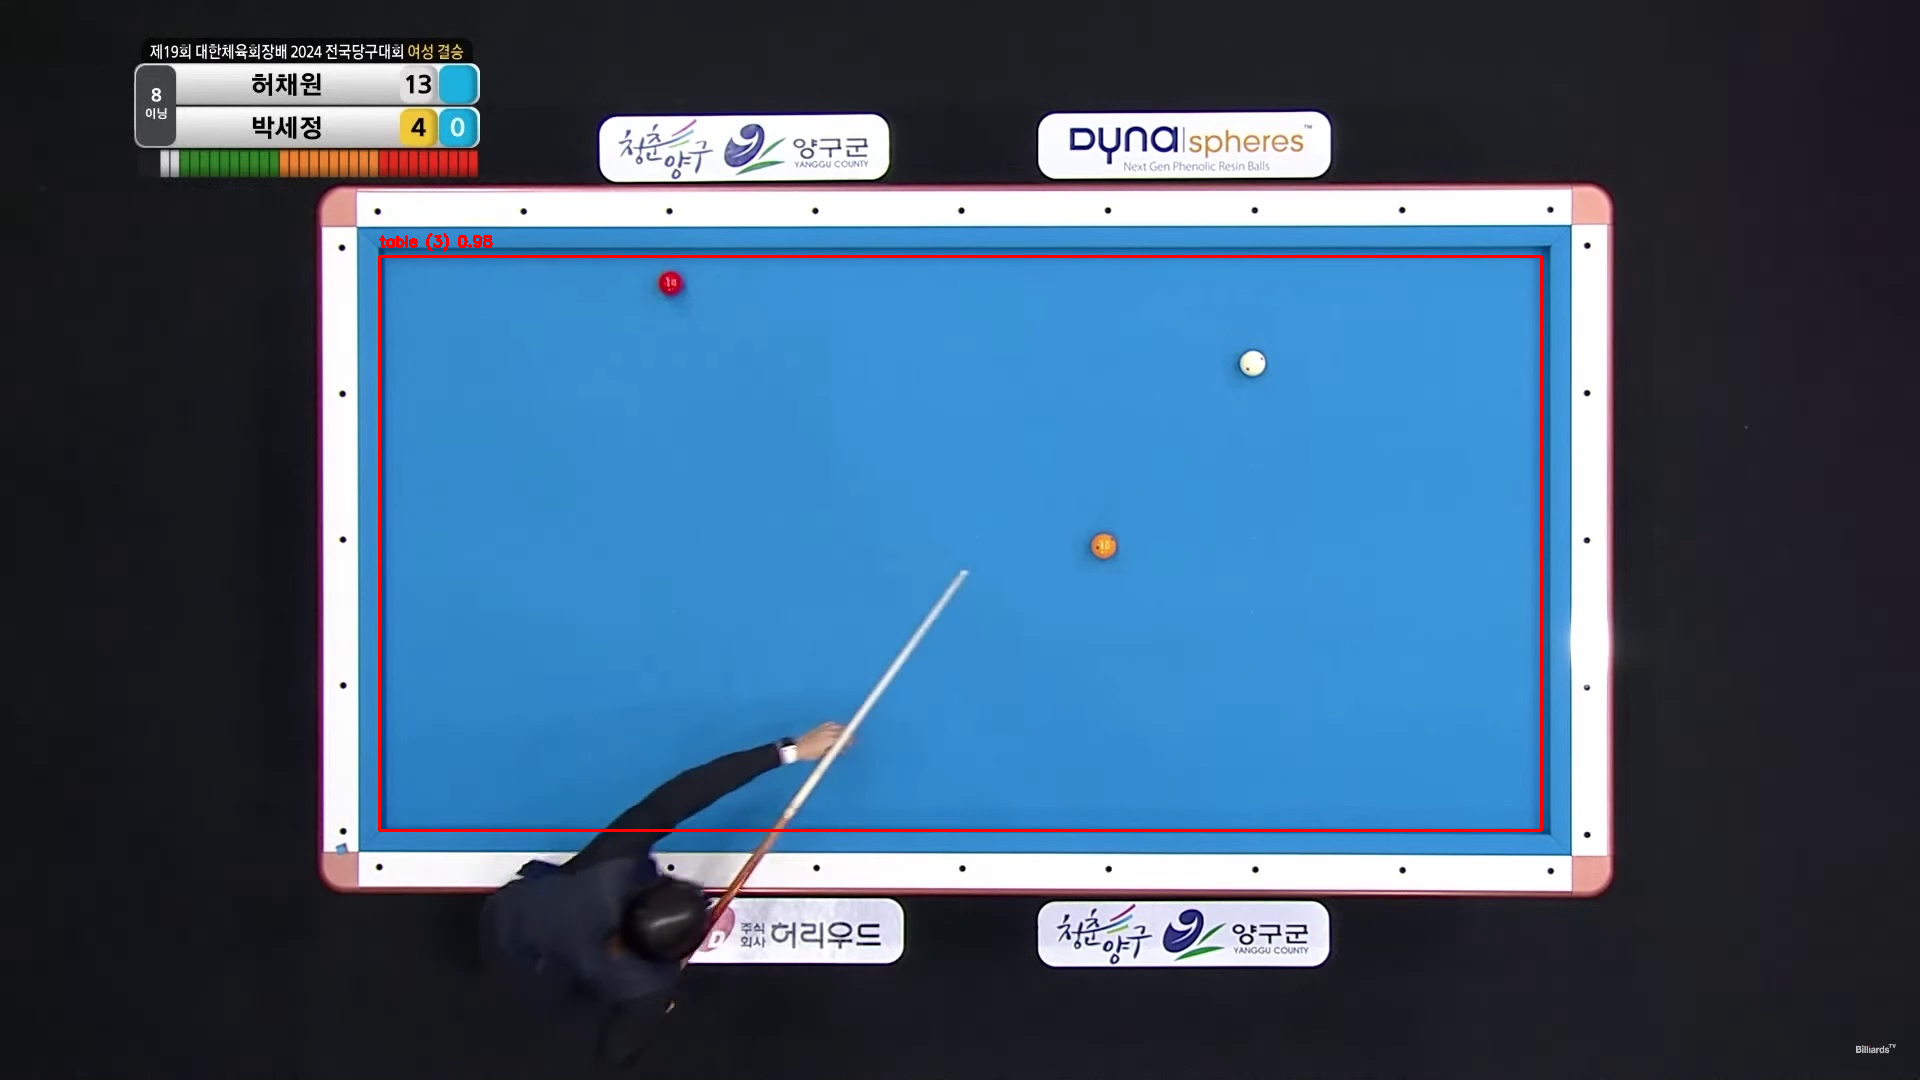

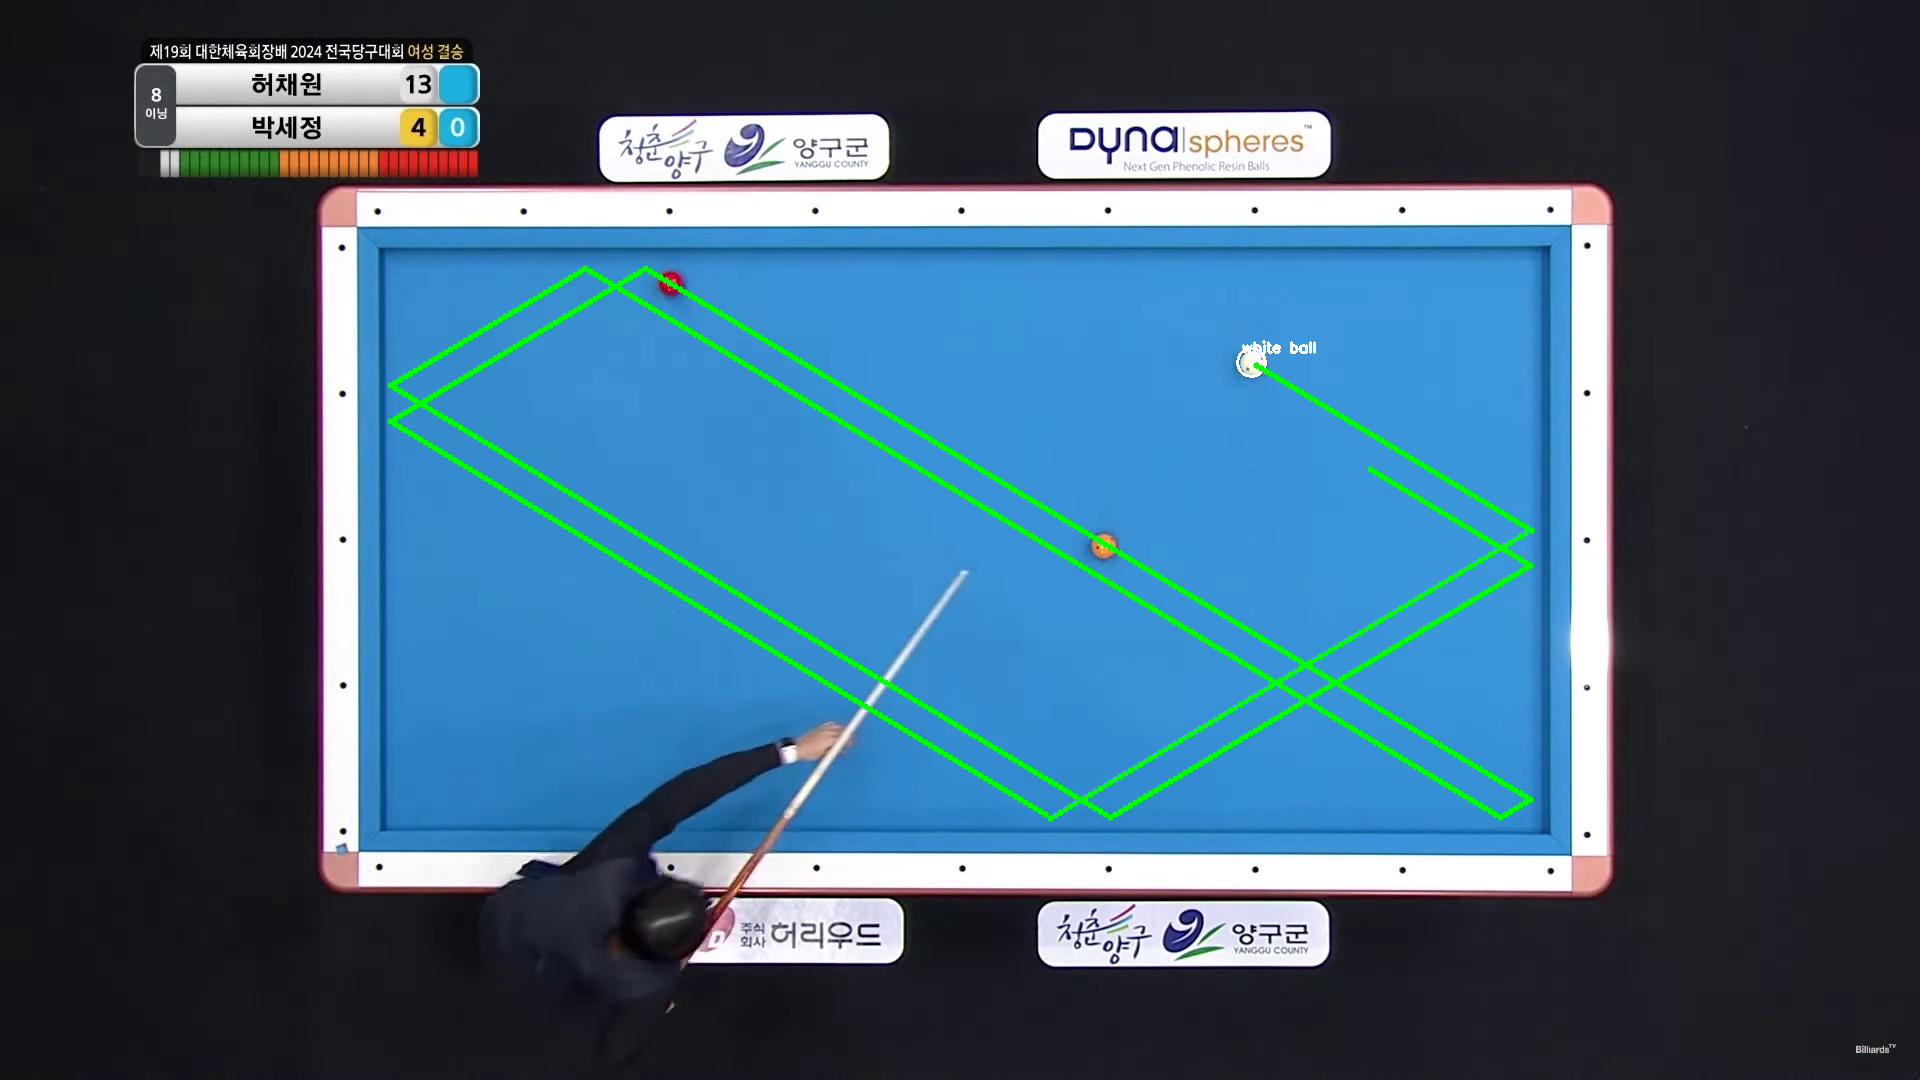

In [4]:
# -------------------------------------------------------------------------------------------
# 2025.01.03, neh
# pymunk를 이용하여 이미지를 읽고 테이블 크기 내에서 공의 경로를 그리도록 처리
# 2025.01.08 기능추가: 공을 수구와 목적구로 나누고, 각 공을 맞추는 기능 추가
#
# 수구(내볼) 을 기준으로 목적공을 맞추는 경로를 계산하는데 스탭수만큼 돌리는 기능!
# -------------------------------------------------------------------------------------------

import cv2
from ultralytics import YOLO  # YOLOv8 객체 탐지 라이브러리
import pymunk
from pymunk import Vec2d
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지를 표시하기 위한 라이브러리

# YOLO 모델 로드
model = YOLO("/content/drive/MyDrive/qpit_prj/data/best_Mansoon.pt")

# 이미지 읽기 (사용자 제공 이미지로 수정 가능)
image_path = '/content/drive/MyDrive/Billiard/Input_mp4/frames/single_frame.jpg'
image = cv2.imread(image_path)

# 서버에서 공 정보를 기준으로 설정
process_ball_info = "white ball" #"yellow ball"  # 서버에서 전달받은 공 종류 정보

# YOLO 모델로 이미지 분석
results = model(image)
class_names = model.names  # 모델에 저장된 클래스 이름들

# 이미지 복사본 생성 (결과 표시용)
output_image = image.copy()

# 테이블 박스 초기화
table_box = None

# YOLO 결과에서 테이블과 공 탐지
for detection in results[0].boxes:
    box = detection.xyxy[0].tolist()  # [x1, y1, x2, y2] 형태의 바운딩 박스 좌표
    class_id = int(detection.cls[0])  # 탐지된 객체의 클래스 ID
    confidence = detection.conf[0]  # 탐지 신뢰도
    class_name = class_names[class_id]  # 클래스 이름

    # 테이블 객체 탐지
    if class_name == "table":
        table_box = box  # 테이블 박스 설정
        cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
        text = f"{class_name} ({class_id}) {confidence:.2f}"
        cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# 탐지된 결과를 화면에 표시
cv2_imshow(output_image)

# 공 탐지 및 그리기 함수
def detector_org_cuball(image, target_ball_info):
    """
    이미지에서 지정된 공(target_ball_info)을 탐지하여 위치와 반지름 반환,
    탐지된 공을 이미지 위에 그림.
    """
    color_map = {
        "yellow ball": (0, 255, 255),  # 노란색 (BGR)
        "white ball": (255, 255, 255)  # 흰색 (BGR)
    }

    for detection in results[0].boxes:
        box = detection.xyxy[0].tolist()  # 바운딩 박스 좌표 [x1, y1, x2, y2]
        class_id = int(detection.cls[0])  # 클래스 ID
        class_name = class_names[class_id]  # 탐지된 클래스 이름

        if class_name == target_ball_info:  # 지정된 공과 일치하는 경우
            x = int((box[0] + box[2]) // 2)  # 중심 X 좌표
            y = int((box[1] + box[3]) // 2)  # 중심 Y 좌표
            radius = int((box[2] - box[0]) // 2)  # 반지름

            # 공을 이미지 위에 그림
            if target_ball_info in color_map:
                cv2.circle(image, (x, y), radius, color_map[target_ball_info], 2)  # 원형 테두리 그림
                cv2.putText(image, f"{target_ball_info}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color_map[target_ball_info], 2)  # 텍스트 추가

            return (x, y), radius  # 탐지된 공의 위치와 반지름 반환

    return None, None  # 공을 탐지하지 못한 경우


# Pymunk 물리 엔진 초기화
def setup_physics(space, table_box):
    """
    Pymunk 공간 초기화 및 테이블 벽 정의
    """
    space.gravity = (0, 0)  # 중력 비활성화
    t_x1, t_y1, t_x2, t_y2 = map(int, table_box)

    # 테이블의 네 벽 정의
    static_lines = [
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x2, t_y1), 1),  # 상단 벽
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x1, t_y2), 1),  # 좌측 벽
        pymunk.Segment(space.static_body, (t_x2, t_y1), (t_x2, t_y2), 1),  # 우측 벽
        pymunk.Segment(space.static_body, (t_x1, t_y2), (t_x2, t_y2), 1),  # 하단 벽
    ]

    for line in static_lines:
        line.elasticity = 1.0  # 반발 계수 설정
        space.add(line)

# 경로 시뮬레이션 함수
def simulate_bounce_path(space, start_pos, radius_new, velocity, table_box, max_bounces):
    """
    지정된 공의 경로를 시뮬레이션하고 경로 점 반환
    """
    body = pymunk.Body(mass=1, moment=10)
    body.position = start_pos
    body.velocity = velocity
    ball = pymunk.Circle(body, radius_new)
    ball.elasticity = 1.0
    space.add(body, ball)

    trajectory_points = []
    bounces = 0

    # 시뮬레이션 진행
    for _ in range(1000):  # 최대 1000번 반복
        space.step(0.01)  # 시간 단위 진행
        trajectory_points.append((int(body.position.x), int(body.position.y)))

        # 공이 벽에 부딪힌 경우
        if (body.position.x <= 0 or body.position.x >= table_box[2] or
            body.position.y <= 0 or body.position.y >= table_box[3]):
            bounces += 1
        if bounces >= max_bounces:  # 최대 튕김 횟수 초과 시 종료
            break

    return trajectory_points

# Pymunk 공간 생성
space = pymunk.Space()
if table_box:
    setup_physics(space, table_box)

# 서버에서 설정한 공을 기준으로 탐지 및 경로 계산
start_pos, radius_new = detector_org_cuball(image, process_ball_info)
if start_pos:
    trajectory = simulate_bounce_path(space, start_pos, radius_new, (500, 300), list(map(int, table_box)), 4)

    # 계산된 경로를 이미지에 그리기
    for point in trajectory:
        cv2.circle(image, point, 3, (0, 255, 0), -1)  # 초록색 점으로 경로 표시

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
